# Lab 2: Cats vs Dogs

**Deadline**: Oct 8, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1xTc7Md7QLR93NLr6wnkQPiWuX_UQjNe0?usp=sharing


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch) 
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)//(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

0 tensor([3])
1 tensor([5])
2 tensor([3])
3 tensor([3])
4 tensor([3])
5 tensor([3])
6 tensor([5])
7 tensor([3])
8 tensor([3])
9 tensor([5])
10 tensor([3])
11 tensor([5])
12 tensor([5])
13 tensor([5])
14 tensor([5])


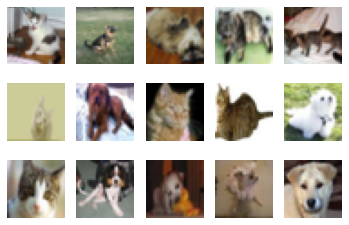

In [ ]:
import matplotlib.pyplot as plt

# print(classes)

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    print(k, labels)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
len(train_loader)

8000

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
# Validation sets are used to tune the parameters of a model
# And to avoid overfitting

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
# by observation, small_net = 8
# by observation, large_net = 16

print("small_net:")
for param in small_net.parameters():
    print(param.shape)

print()
print("large_net:")
for param in large_net.parameters():
    print(param.shape)


small_net:
torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])

large_net:
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
# batch_size=64
# learning_rate=0.01
# num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
# The files would be:
# 1) model_small_bs64_lr0.01_epoch30_train_err.csv
# 2) model_small_bs64_lr0.01_epoch30_train_loss.csv
# 3) model_small_bs64_lr0.01_epoch30_val_err.csv
# 4) model_small_bs64_lr0.01_epoch30_val_loss.csv

"""
WHAT DO THESE FILES CONTAIN?

 model_small_bs64_lr0.01_epoch0
 model_small_bs64_lr0.01_epoch1
 model_small_bs64_lr0.01_epoch2
 model_small_bs64_lr0.01_epoch3
 model_small_bs64_lr0.01_epoch4
 model_small_bs64_lr0.01_epoch4_train_err.csv
 model_small_bs64_lr0.01_epoch4_train_loss.csv
 model_small_bs64_lr0.01_epoch4_val_err.csv
 model_small_bs64_lr0.01_epoch4_val_loss.csv

"""

'\nWHAT DO THESE FILES CONTAIN?\n\n model_small_bs64_lr0.01_epoch0\n model_small_bs64_lr0.01_epoch1\n model_small_bs64_lr0.01_epoch2\n model_small_bs64_lr0.01_epoch3\n model_small_bs64_lr0.01_epoch4\n model_small_bs64_lr0.01_epoch4_train_err.csv\n model_small_bs64_lr0.01_epoch4_train_loss.csv\n model_small_bs64_lr0.01_epoch4_val_err.csv\n model_small_bs64_lr0.01_epoch4_val_loss.csv\n\n'

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive/')

# to compute training time
import time

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
small_net = SmallNet()
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426625, Train loss: 0.6739559087753296 |Validation err: 0.383, Validation loss: 0.6549151036888361
Epoch 2: Train err: 0.36325, Train loss: 0.6435285310745239 |Validation err: 0.374, Validation loss: 0.6506030689924955
Epoch 3: Train err: 0.3515, Train loss: 0.6271873984336853 |Validation err: 0.3455, Validation loss: 0.6228150818496943
Epoch 4: Train err: 0.332375, Train loss: 0.6105248432159424 |Validation err: 0.353, Validation loss: 0.6260843072086573
Epoch 5: Train err: 0.319375, Train loss: 0.6004199092388153 |Validation err: 0.33, Validation loss: 0.6157662402838469
Epoch 6: Train err: 0.308875, Train loss: 0.5874258906841278 |Validation err: 0.3285, Validation loss: 0.6108384262770414
Epoch 7: Train err: 0.308625, Train loss: 0.5817209990024567 |Validation err: 0.3235, Validation loss: 0.600909810513258
Epoch 8: Train err: 0.301, Train loss: 0.5744204039573669 |Validation err: 0.32

In [ ]:
large_net = LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4445, Train loss: 0.6900211296081543 |Validation err: 0.4305, Validation loss: 0.6807530950754881
Epoch 2: Train err: 0.419, Train loss: 0.6781971750259399 |Validation err: 0.413, Validation loss: 0.6741084903478622
Epoch 3: Train err: 0.39875, Train loss: 0.6658558468818665 |Validation err: 0.3935, Validation loss: 0.6518439128994942
Epoch 4: Train err: 0.3745, Train loss: 0.6489967885017395 |Validation err: 0.414, Validation loss: 0.6675047222524881
Epoch 5: Train err: 0.35575, Train loss: 0.6334396615028381 |Validation err: 0.3555, Validation loss: 0.6298687160015106
Epoch 6: Train err: 0.3405, Train loss: 0.616027752161026 |Validation err: 0.3425, Validation loss: 0.6155525054782629
Epoch 7: Train err: 0.326, Train loss: 0.6002030911445617 |Validation err: 0.335, Validation loss: 0.609481131657958
Epoch 8: Train err: 0.31075, Train loss: 0.5829655594825744 |Validation err: 0.3275, Vali

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [ ]:
# exploring filesystem
! ls -la

total 9900
drwxr-xr-x 1 root root 20480 Oct  8 17:34 .
drwxr-xr-x 1 root root  4096 Oct  8 10:28 ..
drwxr-xr-x 1 root root  4096 Oct  5 16:31 .config
drwxr-xr-x 3 root root  4096 Oct  8 10:29 data
drwx------ 5 root root  4096 Oct  8 14:34 gdrive
-rw-r--r-- 1 root root 41548 Oct  8 12:08 model_large_bs16_lr0.01_epoch0
-rw-r--r-- 1 root root 41548 Oct  8 12:08 model_large_bs16_lr0.01_epoch1
-rw-r--r-- 1 root root 41548 Oct  8 12:09 model_large_bs16_lr0.01_epoch10
-rw-r--r-- 1 root root 41548 Oct  8 12:09 model_large_bs16_lr0.01_epoch11
-rw-r--r-- 1 root root 41548 Oct  8 12:09 model_large_bs16_lr0.01_epoch12
-rw-r--r-- 1 root root 41548 Oct  8 12:09 model_large_bs16_lr0.01_epoch13
-rw-r--r-- 1 root root 41548 Oct  8 12:09 model_large_bs16_lr0.01_epoch14
-rw-r--r-- 1 root root 41548 Oct  8 12:09 model_large_bs16_lr0.01_epoch15
-rw-r--r-- 1 root root 41548 Oct  8 12:09 model_large_bs16_lr0.01_epoch16
-rw-r--r-- 1 root root 41548 Oct  8 12:09 model_large_bs16_lr0.01_epoch17
-rw-r--r-- 1 roo

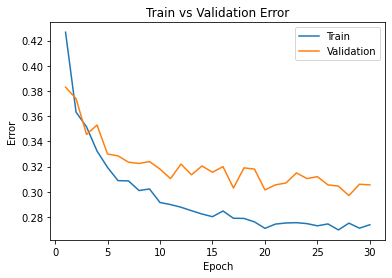

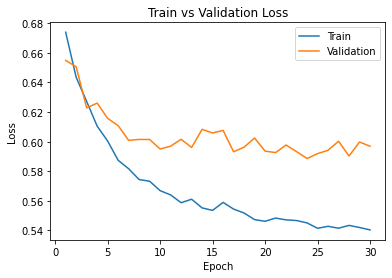

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

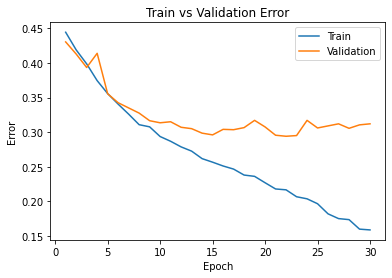

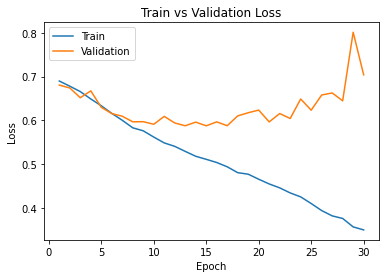

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# small_net has a better fitting than large_net
# large_net has the issue of overfitting

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Based on observation, 
# It takes shorter time than the default large_net configuration (~1s)
# It also has a better fit than that of the default

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686543643475
Epoch 2: Train err: 0.448625, Train loss: 0.6922589735984802 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067390441895 |Validation err: 0.4285, Validation loss: 0.6908544506877661
Epoch 4: Train err: 0.430125, Train loss: 0.6908613820075988 |Validation err: 0.424, Validation loss: 0.6896596867591143
Epoch 5: Train err: 0.434125, Train loss: 0.6899198398590088 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419700622559 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781762123108 |Validation err: 0.4185, Validation loss: 0.6851996630430222
Epoch 8: Train err: 0.43725, Train loss: 0.6859267873764038 |Validation err

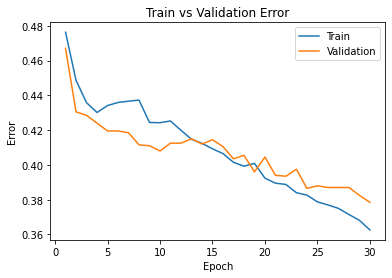

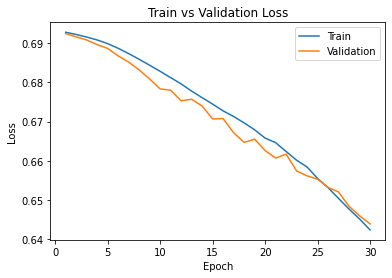

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
# Based on observation, 
# It takes shorter time than the default configuration (~3s), 
# and shorter than that of lr=0.01 (~2)
# But, the fitting is much worse than the other two

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4275, Train loss: 0.6742977547645569 |Validation err: 0.3765, Validation loss: 0.6370316985994577
Epoch 2: Train err: 0.369625, Train loss: 0.6419942178726197 |Validation err: 0.375, Validation loss: 0.6421687360852957
Epoch 3: Train err: 0.36025, Train loss: 0.6315926456451416 |Validation err: 0.338, Validation loss: 0.6223371177911758
Epoch 4: Train err: 0.334125, Train loss: 0.6084355125427247 |Validation err: 0.333, Validation loss: 0.6210155226290226
Epoch 5: Train err: 0.327, Train loss: 0.5968132178783416 |Validation err: 0.316, Validation loss: 0.593926228582859
Epoch 6: Train err: 0.3065, Train loss: 0.5736211636066437 |Validation err: 0.308, Validation loss: 0.5758339520543814
Epoch 7: Train err: 0.286625, Train loss: 0.557759182214737 |Validation err: 0.3255, Validation loss: 0.5994757367298007
Epoch 8: Train err: 0.287625, Train loss: 0.5451903882026672 |Validation err: 0.3075,

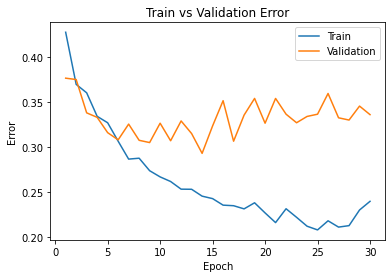

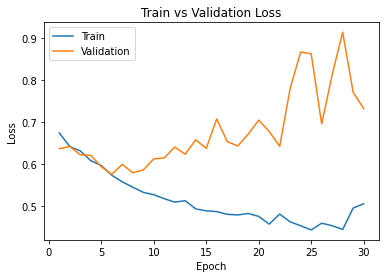

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
# Based on observation, 
# It takes shorter time than the default small_net configuration (~17s)
# And the fitting is better that the default too

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379440844059 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103945493698 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500553488731 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449865877628 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935664117336 |Validation err: 0.424, Validation loss: 0.6881355196237564
Epoch 6: Train err: 0.438, Train loss: 0.6883532032370567 |Validation err: 0.4285, Validation loss: 0.6860118806362152
Epoch 7: Train err: 0.439375, Train loss: 0.6866871640086174 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, 

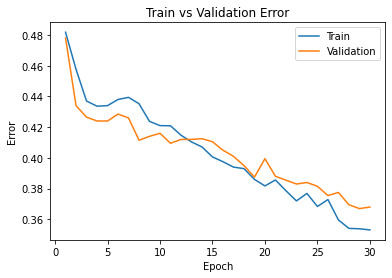

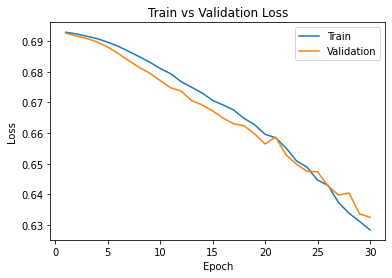

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512)

model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
# Based on observation, 
# It takes longer time than the default configuration (~61s), 
# and longer than that of bs=512 (~78)
# The fitting is much worse than the other two too, very much overfitted

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775410465598106 |Validation err: 0.3785, Validation loss: 0.651269543170929
Epoch 2: Train err: 0.367875, Train loss: 0.6389183864593506 |Validation err: 0.3495, Validation loss: 0.6170854353904724
Epoch 3: Train err: 0.340375, Train loss: 0.6114947981238366 |Validation err: 0.343, Validation loss: 0.6361264021396636
Epoch 4: Train err: 0.31175, Train loss: 0.5834803532958031 |Validation err: 0.3415, Validation loss: 0.6126863491535187
Epoch 5: Train err: 0.301125, Train loss: 0.5638278910517692 |Validation err: 0.311, Validation loss: 0.5762235834598541
Epoch 6: Train err: 0.28475, Train loss: 0.5464649626612663 |Validation err: 0.3045, Validation loss: 0.5770110754966736
Epoch 7: Train err: 0.270625, Train loss: 0.5266695675551891 |Validation err: 0.2965, Validation loss: 0.5703191385269165
Epoch 8: Train err: 0.254, Train loss: 0.5092709631323814 |Validation err: 

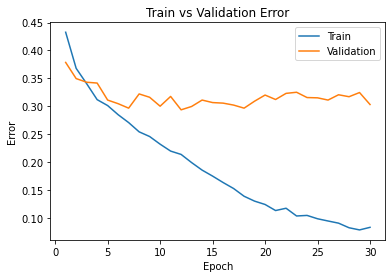

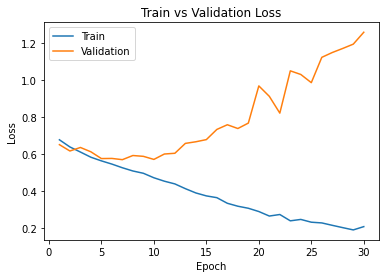

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16)

model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# the best graphs were the ones on part 3a and part 3b. So I'm going to combine
# them both

# Thus, let's use the following configuration on a large_net
# lr = 0.001
# bs = 512

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677406489849 |Validation err: 0.4955, Validation loss: 0.6931362003087997
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280385375023 |Validation err: 0.493, Validation loss: 0.6929539442062378
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.6928706765174866
Epoch 5: Train err: 0.473375, Train loss: 0.6927744261920452 |Validation err: 0.4835, Validation loss: 0.6927504688501358
Epoch 6: Train err: 0.469, Train loss: 0.6926896162331104 |Validation err: 0.472, Validation loss: 0.69265516102314
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

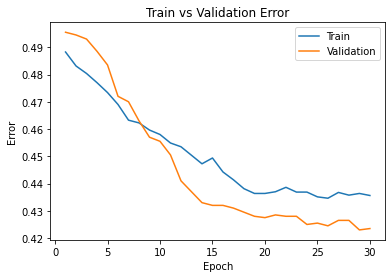

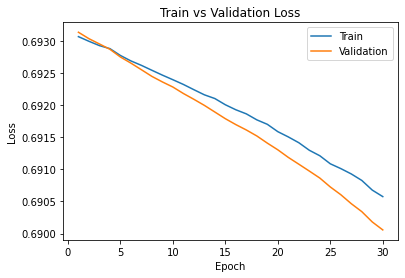

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001)

model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
# Using default configuration on small_net was better than on large_net when we 
# first ran it
# It had a better fit and shorter training time

# Thus, I'm going to use the same configuration but on small_net this time

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.5005, Train loss: 0.6991336420178413 |Validation err: 0.4925, Validation loss: 0.6945076286792755
Epoch 2: Train err: 0.48, Train loss: 0.6934637613594532 |Validation err: 0.4755, Validation loss: 0.691897839307785
Epoch 3: Train err: 0.48175, Train loss: 0.691833857446909 |Validation err: 0.465, Validation loss: 0.6914202123880386
Epoch 4: Train err: 0.472375, Train loss: 0.6913324184715748 |Validation err: 0.4645, Validation loss: 0.6911139786243439
Epoch 5: Train err: 0.469125, Train loss: 0.6907239966094494 |Validation err: 0.4565, Validation loss: 0.6905251294374466
Epoch 6: Train err: 0.466875, Train loss: 0.690356221050024 |Validation err: 0.459, Validation loss: 0.6900540888309479
Epoch 7: Train err: 0.4635, Train loss: 0.6899680867791176 |Validation err: 0.4625, Validation loss: 0.6895745396614075
Epoch 8: Train err: 0.461, Train loss: 0.6896125338971615 |Validation err: 0.4605, V

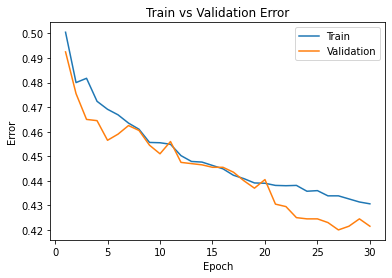

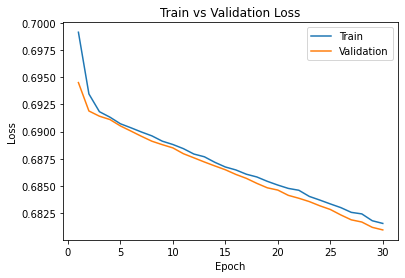

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001)

model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.001, epoch=24)
state = torch.load(model_path)
net.load_state_dict(state)

# This configuration is obtained through the exercise below 

<All keys matched successfully>

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.5005, Train loss: 0.6991336420178413 |Validation err: 0.4925, Validation loss: 0.6945076286792755
Epoch 2: Train err: 0.48, Train loss: 0.6934637613594532 |Validation err: 0.4755, Validation loss: 0.691897839307785
Epoch 3: Train err: 0.48175, Train loss: 0.691833857446909 |Validation err: 0.465, Validation loss: 0.6914202123880386
Epoch 4: Train err: 0.472375, Train loss: 0.6913324184715748 |Validation err: 0.4645, Validation loss: 0.6911139786243439
Epoch 5: Train err: 0.469125, Train loss: 0.6907239966094494 |Validation err: 0.4565, Validation loss: 0.6905251294374466
Epoch 6: Train err: 0.466875, Train loss: 0.690356221050024 |Validation err: 0.459, Validation loss: 0.6900540888309479
Epoch 7: Train err: 0.4635, Train loss: 0.6899680867791176 |Validation err: 0.4625, Validation loss: 0.6895745396614075
Epoch 8: Train err: 0.461, Train loss: 0.6896125338971615 |Validation err: 0.4605, V

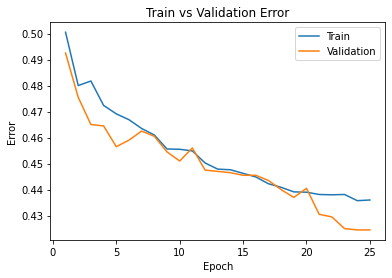

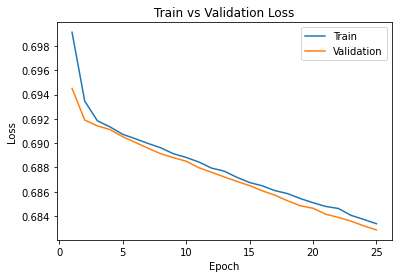

In [ ]:
# The next set of cells are used to test num_epoc

# The best configuration is as follows
small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=25)

model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=24)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.5005, Train loss: 0.6991336420178413 |Validation err: 0.4925, Validation loss: 0.6945076286792755
Epoch 2: Train err: 0.48, Train loss: 0.6934637613594532 |Validation err: 0.4755, Validation loss: 0.691897839307785
Epoch 3: Train err: 0.48175, Train loss: 0.691833857446909 |Validation err: 0.465, Validation loss: 0.6914202123880386
Epoch 4: Train err: 0.472375, Train loss: 0.6913324184715748 |Validation err: 0.4645, Validation loss: 0.6911139786243439
Epoch 5: Train err: 0.469125, Train loss: 0.6907239966094494 |Validation err: 0.4565, Validation loss: 0.6905251294374466
Epoch 6: Train err: 0.466875, Train loss: 0.690356221050024 |Validation err: 0.459, Validation loss: 0.6900540888309479
Epoch 7: Train err: 0.4635, Train loss: 0.6899680867791176 |Validation err: 0.4625, Validation loss: 0.6895745396614075
Epoch 8: Train err: 0.461, Train loss: 0.6896125338971615 |Validation err: 0.4605, V

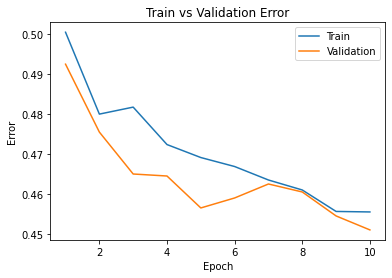

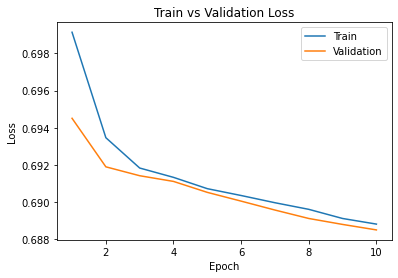

In [ ]:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing cells begin

small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=10)

model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=9)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.490625, Train loss: 0.6920717656612396 |Validation err: 0.49, Validation loss: 0.6917801201343536
Epoch 2: Train err: 0.4835, Train loss: 0.6914130710065365 |Validation err: 0.485, Validation loss: 0.6912703067064285
Epoch 3: Train err: 0.473625, Train loss: 0.6907926313579082 |Validation err: 0.4795, Validation loss: 0.690857395529747
Epoch 4: Train err: 0.463375, Train loss: 0.6901675090193748 |Validation err: 0.473, Validation loss: 0.6903717070817947
Epoch 5: Train err: 0.455375, Train loss: 0.689484391361475 |Validation err: 0.47, Validation loss: 0.6897505223751068
Epoch 6: Train err: 0.454, Train loss: 0.6889744959771633 |Validation err: 0.4635, Validation loss: 0.6890954077243805
Epoch 7: Train err: 0.45025, Train loss: 0.6883171163499355 |Validation err: 0.4565, Validation loss: 0.688525453209877
Epoch 8: Train err: 0.44675, Train loss: 0.6876671090722084 |Validation err: 0.4565, 

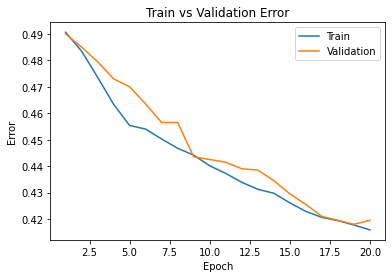

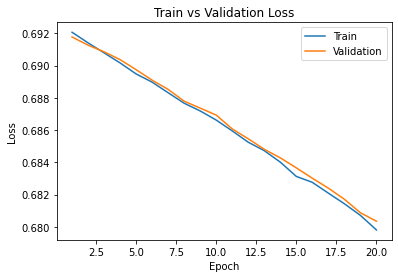

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=20)

model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=19)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49875, Train loss: 0.7186486981809139 |Validation err: 0.512, Validation loss: 0.715241551399231
Epoch 2: Train err: 0.49475, Train loss: 0.6995233073830605 |Validation err: 0.501, Validation loss: 0.6966764032840729
Epoch 3: Train err: 0.464, Train loss: 0.6904545314610004 |Validation err: 0.4605, Validation loss: 0.6899094134569168
Epoch 4: Train err: 0.43525, Train loss: 0.6872168071568012 |Validation err: 0.4395, Validation loss: 0.6867328733205795
Epoch 5: Train err: 0.424, Train loss: 0.6852649338543415 |Validation err: 0.428, Validation loss: 0.6845970004796982
Epoch 6: Train err: 0.4245, Train loss: 0.6836918033659458 |Validation err: 0.4245, Validation loss: 0.6828576326370239
Epoch 7: Train err: 0.420625, Train loss: 0.682029951363802 |Validation err: 0.421, Validation loss: 0.681281715631485
Epoch 8: Train err: 0.418, Train loss: 0.6804911941289902 |Validation err: 0.415, Valida

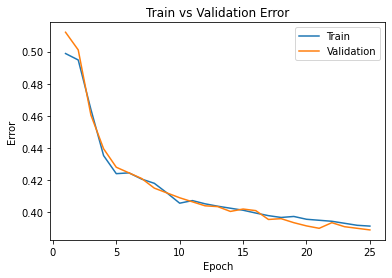

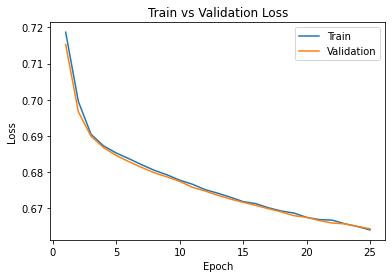

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=25)

model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=24)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.489125, Train loss: 0.6934471651911736 |Validation err: 0.4755, Validation loss: 0.6931312084197998
Epoch 2: Train err: 0.48725, Train loss: 0.6928777918219566 |Validation err: 0.4725, Validation loss: 0.6922577023506165
Epoch 3: Train err: 0.4835, Train loss: 0.6922521218657494 |Validation err: 0.464, Validation loss: 0.6916478723287582
Epoch 4: Train err: 0.476375, Train loss: 0.6916652731597424 |Validation err: 0.457, Validation loss: 0.6910142749547958
Epoch 5: Train err: 0.469625, Train loss: 0.6909874379634857 |Validation err: 0.4495, Validation loss: 0.6903643161058426
Epoch 6: Train err: 0.464, Train loss: 0.6904886029660702 |Validation err: 0.4415, Validation loss: 0.6896762996912003
Epoch 7: Train err: 0.457875, Train loss: 0.6899658516049385 |Validation err: 0.4365, Validation loss: 0.6890884339809418
Epoch 8: Train err: 0.456375, Train loss: 0.6893639862537384 |Validation err: 

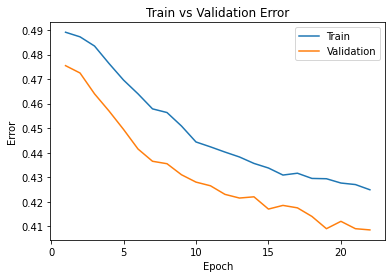

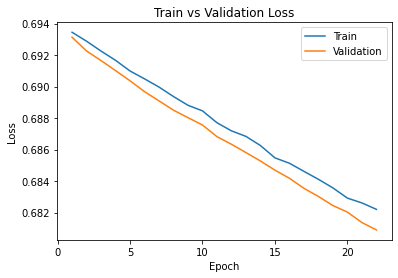

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=22)

model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=21)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.489875, Train loss: 0.6948323585093021 |Validation err: 0.5, Validation loss: 0.6941235512495041
Epoch 2: Train err: 0.486125, Train loss: 0.6932278014719486 |Validation err: 0.4885, Validation loss: 0.6928317099809647
Epoch 3: Train err: 0.48475, Train loss: 0.6918732337653637 |Validation err: 0.4835, Validation loss: 0.6917708367109299
Epoch 4: Train err: 0.476125, Train loss: 0.6909450739622116 |Validation err: 0.474, Validation loss: 0.6909283697605133
Epoch 5: Train err: 0.46725, Train loss: 0.6899744756519794 |Validation err: 0.4755, Validation loss: 0.690032109618187
Epoch 6: Train err: 0.460125, Train loss: 0.689124658703804 |Validation err: 0.464, Validation loss: 0.6892208606004715
Epoch 7: Train err: 0.451375, Train loss: 0.6883765533566475 |Validation err: 0.455, Validation loss: 0.6881132125854492
Epoch 8: Train err: 0.44275, Train loss: 0.6876667737960815 |Validation err: 0.4

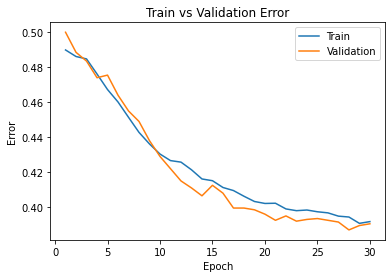

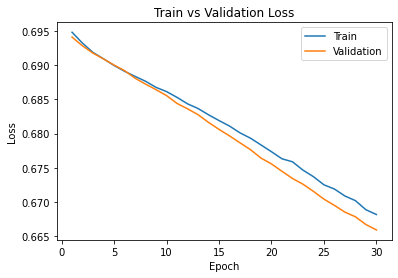

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=30)

model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing cells end

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# Because it is the quickest and also has the best fit
# according to my observations from the previous parts

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# # set batch_size > 1

# question dafault given was:
# train_loader, val_loader, test_loader, classes = get_data_loader(
#     target_classes=["cat", "dog"], 
#     batch_size=64)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# evaluating test_loader
criterion = nn.BCEWithLogitsLoss()
evaluate(net, test_loader, criterion)

(0.4435, 0.6834540069103241)

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# evaluating val_loader
criterion = nn.BCEWithLogitsLoss()
evaluate(net, val_loader, criterion)

(0.4245, 0.6827666014432907)

In [ ]:
# it's the average classification error over the validation set
# so test has to be higher

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# we don't want to risk overfitting
# The model parameters would have been tuned to test_data if we used it and give
# us a false sense that our model is accurate when it was actually trained on it

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
# Sample Code

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

pigeon = Pigeon()

# load the data
mnist_data = datasets.MNIST('data', train=True, download=True)
mnist_data = list(mnist_data)
mnist_train = mnist_data[:1000]
mnist_val   = mnist_data[1000:2000]
img_to_tensor = transforms.ToTensor()

mnist_train, mnist_val, mnist_val, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1)
      
    
# simplified training code to train `pigeon` on the "small digit recognition" task
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(pigeon.parameters(), lr=0.005, momentum=0.9)

for (image, label) in mnist_train:
    # actual ground truth: is the digit less than 3?
    actual = torch.tensor(label == "cat" or label == "dog").reshape([1,1]).type(torch.FloatTensor)
    # pigeon prediction
    out = pigeon(img_to_tensor(image)) # step 1-2
    # update the parameters based on the loss
    loss = criterion(out, actual)      # step 3
    loss.backward()                    # step 4 (compute the updates for each parameter)
    optimizer.step()                   # step 4 (make the updates for each parameter)
    optimizer.zero_grad()              # a clean up step for PyTorch

# computing the error and accuracy on the training set
error = 0
for (image, label) in mnist_train:
    prob = torch.sigmoid(pigeon(img_to_tensor(image)))
    if (prob < 0.5 and label < 3) or (prob >= 0.5 and label >= 3):
        error += 1
print("Training Error Rate:", error/len(mnist_train))
print("Training Accuracy:", 1 - error/len(mnist_train))
final_training_sample = 1 - error/len(mnist_val)

# computing the error and accuracy on a test set
error = 0
for (image, label) in mnist_val:
    prob = torch.sigmoid(pigeon(img_to_tensor(image)))
    if (prob < 0.5 and label < 3) or (prob >= 0.5 and label >= 3):
        error += 1
print("Test Error Rate:", error/len(mnist_val))
print("Test Accuracy:", 1 - error/len(mnist_val))
final_test_sample = 1 - error/len(mnist_val)

Files already downloaded and verified
Files already downloaded and verified


TypeError: ignored